# Travelogues MLP classification

In [ ]:
# https://www.tensorflow.org/hub/tutorials/text_classification_with_tf_hub
# https://www.tensorflow.org/tutorials/keras/text_classification_with_hub

## Loading data

In [1]:
# legacy ground truth
# True uses only the ground truth used for the creation of the paper, False also inludes travelogues added later
legacy = True

# century
# this defines the century to be used, see travelogues-corpus for more info
# valid options: see travelogues-corpus
century = '16th_century'

In [2]:
# results file
result_output = 'results/results_%s_mlp.csv' % century

# mlp model name - will be used for saving
mlp_model_name = 'models/travelogues_%s_mlp.h5' % century

In [3]:
# loading the data

import os
import random
import numpy as np
from sklearn.model_selection import train_test_split

seed = 42

# Load the training data
train_texts = []
train_labels = []
training_categories = []
books = ''
if legacy is True:
    # data directory
    books = 'groundtruth/%s/' % century
    training_categories = ['travelogues-legacy', 'non-travelogues']
else:
    # data directory
    books = '../travelogues-corpus/%s/books/' % century
    training_categories = ['travelogues', 'non-travelogues']

travel_gt_path = books
    
for category in training_categories:
    train_path = os.path.join(travel_gt_path, category)
    for fname in sorted(os.listdir(train_path)):
        if fname.endswith('.txt'):
            with open(os.path.join(train_path, fname)) as f:
                train_texts.append(f.read())
            train_labels.append(0 if category == 'non-travelogues' else 1)

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(train_texts, train_labels) 

# Shuffle the training data and labels.
random.seed(seed)
random.shuffle(X_train_base)
random.seed(seed)
random.shuffle(y_train_base)

train_labels = np.array(y_train_base)
test_labels = np.array(y_test_base)

train_texts = X_train_base
test_texts = X_test_base

## Info about the data

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def get_num_words_per_sample(sample_texts):
    # median number of words per sample given corpus.
    num_words = [len(s.split()) for s in sample_texts]
    
    return np.median(num_words)

def plot_sample_length_distribution(sample_texts):
    # plot sample length distribution
    
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()

In [5]:
get_num_words_per_sample(train_texts)

23483.5

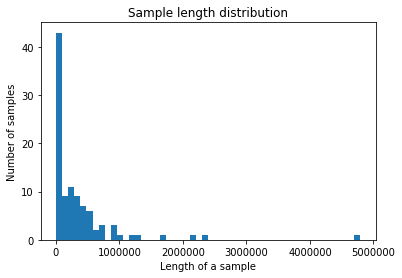

In [6]:
plot_sample_length_distribution(train_texts)

## Vectorize the texts

In [7]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Vectorization parameters
ngram_range = (1, 2)

# Limit on the number of features. We use the top 20K features.
top_features = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
token_mode = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
min_doc_frequency = 2

# Create keyword arguments to pass to the 'tf-idf' vectorizer.
kwargs = {
        'ngram_range': ngram_range,
        'dtype': 'int32',
        'strip_accents': 'unicode',
        'decode_error': 'replace',
        'analyzer': token_mode
}
vectorizer = HashingVectorizer(**kwargs)

# Learn vocabulary from training texts and vectorize training texts.
x_train = vectorizer.fit_transform(train_texts)

# Vectorize validation texts.
x_val = vectorizer.transform(test_texts)

# Select top 'k' of the vectorized features.
selector = SelectKBest(f_classif, k=min(top_features, x_train.shape[1]))
selector.fit(x_train, train_labels)
x_train = selector.transform(x_train).astype('float32')
x_val = selector.transform(x_val).astype('float32')

/home/jan/dev/venv/travelogues-v/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  UserWarning)
/home/jan/dev/venv/travelogues-v/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


## Define MLP

In [8]:
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout

def _get_last_layer_units_and_activation(num_classes):
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))
    return model

#### The following cell needs to be re-run when a saved model is loaded.

In [9]:
import tensorflow.keras.backend as K

def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

def precision(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2
    
    return precision

def recall(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many relevant items are selected?
    recall = c1 / c3
    
    return recall

In [10]:
import tensorflow as tf

def train_ngram_model(learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=2,
                      units=64,
                      dropout_rate=0.2):

    # Verify that validation labels are in the same range as training labels.
    num_classes = 2
    val_labels = y_test_base
    unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
    if len(unexpected_labels):
        raise ValueError('Unexpected label values found in the validation set:'
                         ' {unexpected_labels}. Please make sure that the '
                         'labels in the validation set are in the same range '
                         'as training labels.'.format(
                             unexpected_labels=unexpected_labels))
        
    model = mlp_model(layers=layers,
                                  units=units,
                                  dropout_rate=dropout_rate,
                                  input_shape=x_train.shape[1:],
                                  num_classes=num_classes)

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc', f1_score, precision, recall])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in 50 consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))
    
    # plot history
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Save model.
    model.save(mlp_model_name)
    return history['val_acc'][-1], history['val_loss'][-1]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 100 samples, validate on 34 samples
Epoch 1/1000
100/100 - 1s - loss: 0.6923 - acc: 0.6200 - f1_score: 0.5476 - precision: 0.7188 - recall: 0.4423 - val_loss: 0.6889 - val_acc: 0.6176 - val_f1_score: 0.6977 - val_precision: 0.5357 - val_recall: 1.0000
Epoch 2/1000
100/100 - 0s - loss: 0.6862 - acc: 0.7100 - f1_score: 0.7820 - precision: 0.6420 - recall: 1.0000 - val_loss: 0.6859 - val_acc: 0.5294 - val_f1_score: 0.6522 - val_precision: 0.4839 - val_recall: 1.0000
Epoch 3/1000
100/100 - 0s - loss: 0.6810 - acc: 0.7500 - f1_score: 0.8062 - precision: 0.6753 - recall: 1.0000 - val_loss: 0.6828 - val_acc: 0.5588 - val_f1_score: 0.6667 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/1000
100/100 - 0s - loss: 0.6761 - acc: 0.7300 - f1_score: 0.7939 - precision: 0.6582 - recall: 1.0000 - val_loss: 0.6791 - 

Epoch 36/1000
100/100 - 0s - loss: 0.4373 - acc: 0.9500 - f1_score: 0.9533 - precision: 0.9273 - recall: 0.9808 - val_loss: 0.5244 - val_acc: 0.8529 - val_f1_score: 0.8571 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 37/1000
100/100 - 0s - loss: 0.4320 - acc: 0.9300 - f1_score: 0.9346 - precision: 0.9091 - recall: 0.9615 - val_loss: 0.5196 - val_acc: 0.8529 - val_f1_score: 0.8571 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 38/1000
100/100 - 0s - loss: 0.4341 - acc: 0.9400 - f1_score: 0.9434 - precision: 0.9259 - recall: 0.9615 - val_loss: 0.5149 - val_acc: 0.8529 - val_f1_score: 0.8571 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 39/1000
100/100 - 0s - loss: 0.4302 - acc: 0.9500 - f1_score: 0.9541 - precision: 0.9123 - recall: 1.0000 - val_loss: 0.5102 - val_acc: 0.8529 - val_f1_score: 0.8571 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 40/1000
100/100 - 0s - loss: 0.4195 - acc: 0.9500 - f1_score: 0.9524 - precision: 0.9434 - recall: 0.9615 - val_loss: 0.5055 -

Epoch 74/1000
100/100 - 0s - loss: 0.2491 - acc: 0.9600 - f1_score: 0.9615 - precision: 0.9615 - recall: 0.9615 - val_loss: 0.3815 - val_acc: 0.9118 - val_f1_score: 0.9091 - val_precision: 0.8333 - val_recall: 1.0000
Epoch 75/1000
100/100 - 0s - loss: 0.2417 - acc: 0.9600 - f1_score: 0.9615 - precision: 0.9615 - recall: 0.9615 - val_loss: 0.3792 - val_acc: 0.9118 - val_f1_score: 0.9091 - val_precision: 0.8333 - val_recall: 1.0000
Epoch 76/1000
100/100 - 0s - loss: 0.2457 - acc: 0.9500 - f1_score: 0.9515 - precision: 0.9608 - recall: 0.9423 - val_loss: 0.3769 - val_acc: 0.9118 - val_f1_score: 0.9091 - val_precision: 0.8333 - val_recall: 1.0000
Epoch 77/1000
100/100 - 0s - loss: 0.2360 - acc: 0.9600 - f1_score: 0.9615 - precision: 0.9615 - recall: 0.9615 - val_loss: 0.3746 - val_acc: 0.9118 - val_f1_score: 0.9091 - val_precision: 0.8333 - val_recall: 1.0000
Epoch 78/1000
100/100 - 0s - loss: 0.2404 - acc: 0.9600 - f1_score: 0.9608 - precision: 0.9800 - recall: 0.9423 - val_loss: 0.3723 -

Epoch 112/1000
100/100 - 0s - loss: 0.1568 - acc: 0.9600 - f1_score: 0.9615 - precision: 0.9615 - recall: 0.9615 - val_loss: 0.3172 - val_acc: 0.9118 - val_f1_score: 0.9091 - val_precision: 0.8333 - val_recall: 1.0000
Epoch 113/1000
100/100 - 0s - loss: 0.1490 - acc: 0.9800 - f1_score: 0.9808 - precision: 0.9808 - recall: 0.9808 - val_loss: 0.3159 - val_acc: 0.9118 - val_f1_score: 0.9091 - val_precision: 0.8333 - val_recall: 1.0000
Epoch 114/1000
100/100 - 0s - loss: 0.1477 - acc: 0.9900 - f1_score: 0.9905 - precision: 0.9811 - recall: 1.0000 - val_loss: 0.3146 - val_acc: 0.9118 - val_f1_score: 0.9091 - val_precision: 0.8333 - val_recall: 1.0000
Epoch 115/1000
100/100 - 0s - loss: 0.1547 - acc: 0.9700 - f1_score: 0.9709 - precision: 0.9804 - recall: 0.9615 - val_loss: 0.3135 - val_acc: 0.9118 - val_f1_score: 0.9091 - val_precision: 0.8333 - val_recall: 1.0000
Epoch 116/1000
100/100 - 0s - loss: 0.1461 - acc: 0.9700 - f1_score: 0.9709 - precision: 0.9804 - recall: 0.9615 - val_loss: 0.3

Epoch 150/1000
100/100 - 0s - loss: 0.1064 - acc: 0.9700 - f1_score: 0.9709 - precision: 0.9804 - recall: 0.9615 - val_loss: 0.2850 - val_acc: 0.9118 - val_f1_score: 0.9091 - val_precision: 0.8333 - val_recall: 1.0000
Epoch 151/1000
100/100 - 0s - loss: 0.1119 - acc: 0.9800 - f1_score: 0.9808 - precision: 0.9808 - recall: 0.9808 - val_loss: 0.2845 - val_acc: 0.9118 - val_f1_score: 0.9091 - val_precision: 0.8333 - val_recall: 1.0000
Epoch 152/1000
100/100 - 0s - loss: 0.0977 - acc: 0.9900 - f1_score: 0.9905 - precision: 0.9811 - recall: 1.0000 - val_loss: 0.2839 - val_acc: 0.9118 - val_f1_score: 0.9091 - val_precision: 0.8333 - val_recall: 1.0000
Epoch 153/1000
100/100 - 0s - loss: 0.1097 - acc: 0.9900 - f1_score: 0.9905 - precision: 0.9811 - recall: 1.0000 - val_loss: 0.2830 - val_acc: 0.9118 - val_f1_score: 0.9091 - val_precision: 0.8333 - val_recall: 1.0000
Epoch 154/1000
100/100 - 0s - loss: 0.1037 - acc: 0.9900 - f1_score: 0.9905 - precision: 0.9811 - recall: 1.0000 - val_loss: 0.2

Epoch 188/1000
100/100 - 0s - loss: 0.0686 - acc: 1.0000 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2619 - val_acc: 0.9118 - val_f1_score: 0.9091 - val_precision: 0.8333 - val_recall: 1.0000
Epoch 189/1000
100/100 - 0s - loss: 0.0673 - acc: 1.0000 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2617 - val_acc: 0.9118 - val_f1_score: 0.9091 - val_precision: 0.8333 - val_recall: 1.0000
Epoch 190/1000
100/100 - 0s - loss: 0.0642 - acc: 0.9900 - f1_score: 0.9905 - precision: 0.9811 - recall: 1.0000 - val_loss: 0.2614 - val_acc: 0.9118 - val_f1_score: 0.9091 - val_precision: 0.8333 - val_recall: 1.0000
Epoch 191/1000
100/100 - 0s - loss: 0.0704 - acc: 1.0000 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2614 - val_acc: 0.9118 - val_f1_score: 0.9091 - val_precision: 0.8333 - val_recall: 1.0000
Epoch 192/1000
100/100 - 0s - loss: 0.0657 - acc: 1.0000 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2

Epoch 226/1000
100/100 - 0s - loss: 0.0443 - acc: 1.0000 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2506 - val_acc: 0.9118 - val_f1_score: 0.9091 - val_precision: 0.8333 - val_recall: 1.0000
Epoch 227/1000
100/100 - 0s - loss: 0.0450 - acc: 1.0000 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2503 - val_acc: 0.9118 - val_f1_score: 0.9091 - val_precision: 0.8333 - val_recall: 1.0000
Epoch 228/1000
100/100 - 0s - loss: 0.0557 - acc: 1.0000 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2498 - val_acc: 0.9118 - val_f1_score: 0.9091 - val_precision: 0.8333 - val_recall: 1.0000
Epoch 229/1000
100/100 - 0s - loss: 0.0516 - acc: 1.0000 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2490 - val_acc: 0.9118 - val_f1_score: 0.9091 - val_precision: 0.8333 - val_recall: 1.0000
Epoch 230/1000
100/100 - 0s - loss: 0.0540 - acc: 1.0000 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2

Epoch 264/1000
100/100 - 0s - loss: 0.0360 - acc: 1.0000 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2360 - val_acc: 0.9118 - val_f1_score: 0.9091 - val_precision: 0.8333 - val_recall: 1.0000
Epoch 265/1000
100/100 - 0s - loss: 0.0393 - acc: 1.0000 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2357 - val_acc: 0.9118 - val_f1_score: 0.9091 - val_precision: 0.8333 - val_recall: 1.0000
Epoch 266/1000
100/100 - 0s - loss: 0.0340 - acc: 1.0000 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2354 - val_acc: 0.9118 - val_f1_score: 0.9091 - val_precision: 0.8333 - val_recall: 1.0000
Epoch 267/1000
100/100 - 0s - loss: 0.0364 - acc: 1.0000 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2354 - val_acc: 0.9118 - val_f1_score: 0.9091 - val_precision: 0.8333 - val_recall: 1.0000
Epoch 268/1000
100/100 - 0s - loss: 0.0288 - acc: 1.0000 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2

Epoch 302/1000
100/100 - 0s - loss: 0.0257 - acc: 1.0000 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2320 - val_acc: 0.9118 - val_f1_score: 0.9091 - val_precision: 0.8333 - val_recall: 1.0000
Epoch 303/1000
100/100 - 0s - loss: 0.0229 - acc: 1.0000 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2326 - val_acc: 0.9118 - val_f1_score: 0.9091 - val_precision: 0.8333 - val_recall: 1.0000
Epoch 304/1000
100/100 - 0s - loss: 0.0285 - acc: 1.0000 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2332 - val_acc: 0.9118 - val_f1_score: 0.9091 - val_precision: 0.8333 - val_recall: 1.0000
Epoch 305/1000
100/100 - 0s - loss: 0.0306 - acc: 1.0000 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2335 - val_acc: 0.9118 - val_f1_score: 0.9091 - val_precision: 0.8333 - val_recall: 1.0000
Epoch 306/1000
100/100 - 0s - loss: 0.0321 - acc: 1.0000 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2

Epoch 340/1000
100/100 - 0s - loss: 0.0245 - acc: 1.0000 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2275 - val_acc: 0.9412 - val_f1_score: 0.9375 - val_precision: 0.8824 - val_recall: 1.0000
Epoch 341/1000
100/100 - 0s - loss: 0.0188 - acc: 1.0000 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2279 - val_acc: 0.9412 - val_f1_score: 0.9375 - val_precision: 0.8824 - val_recall: 1.0000
Epoch 342/1000
100/100 - 0s - loss: 0.0238 - acc: 1.0000 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2282 - val_acc: 0.9412 - val_f1_score: 0.9375 - val_precision: 0.8824 - val_recall: 1.0000
Epoch 343/1000
100/100 - 0s - loss: 0.0218 - acc: 1.0000 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2283 - val_acc: 0.9412 - val_f1_score: 0.9375 - val_precision: 0.8824 - val_recall: 1.0000
Epoch 344/1000
100/100 - 0s - loss: 0.0212 - acc: 1.0000 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2

Epoch 378/1000
100/100 - 0s - loss: 0.0171 - acc: 1.0000 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2311 - val_acc: 0.9412 - val_f1_score: 0.9375 - val_precision: 0.8824 - val_recall: 1.0000
Epoch 379/1000
100/100 - 0s - loss: 0.0188 - acc: 1.0000 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2315 - val_acc: 0.9412 - val_f1_score: 0.9375 - val_precision: 0.8824 - val_recall: 1.0000
Epoch 380/1000
100/100 - 0s - loss: 0.0183 - acc: 1.0000 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2316 - val_acc: 0.9412 - val_f1_score: 0.9375 - val_precision: 0.8824 - val_recall: 1.0000
Epoch 381/1000
100/100 - 0s - loss: 0.0150 - acc: 1.0000 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2315 - val_acc: 0.9412 - val_f1_score: 0.9375 - val_precision: 0.8824 - val_recall: 1.0000
Epoch 382/1000
100/100 - 0s - loss: 0.0153 - acc: 1.0000 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2

Epoch 416/1000
100/100 - 0s - loss: 0.0143 - acc: 1.0000 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2219 - val_acc: 0.9412 - val_f1_score: 0.9375 - val_precision: 0.8824 - val_recall: 1.0000
Epoch 417/1000
100/100 - 0s - loss: 0.0132 - acc: 1.0000 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2220 - val_acc: 0.9412 - val_f1_score: 0.9375 - val_precision: 0.8824 - val_recall: 1.0000
Epoch 418/1000
100/100 - 0s - loss: 0.0183 - acc: 1.0000 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2216 - val_acc: 0.9412 - val_f1_score: 0.9375 - val_precision: 0.8824 - val_recall: 1.0000
Epoch 419/1000
100/100 - 0s - loss: 0.0134 - acc: 1.0000 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2211 - val_acc: 0.9412 - val_f1_score: 0.9375 - val_precision: 0.8824 - val_recall: 1.0000
Epoch 420/1000
100/100 - 0s - loss: 0.0178 - acc: 1.0000 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2

Epoch 454/1000
100/100 - 0s - loss: 0.0101 - acc: 1.0000 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2254 - val_acc: 0.9412 - val_f1_score: 0.9375 - val_precision: 0.8824 - val_recall: 1.0000
Epoch 455/1000
100/100 - 0s - loss: 0.0118 - acc: 1.0000 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2253 - val_acc: 0.9412 - val_f1_score: 0.9375 - val_precision: 0.8824 - val_recall: 1.0000
Epoch 456/1000
100/100 - 0s - loss: 0.0123 - acc: 1.0000 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2252 - val_acc: 0.9412 - val_f1_score: 0.9375 - val_precision: 0.8824 - val_recall: 1.0000
Epoch 457/1000
100/100 - 0s - loss: 0.0118 - acc: 1.0000 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2251 - val_acc: 0.9412 - val_f1_score: 0.9375 - val_precision: 0.8824 - val_recall: 1.0000
Epoch 458/1000
100/100 - 0s - loss: 0.0108 - acc: 1.0000 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2

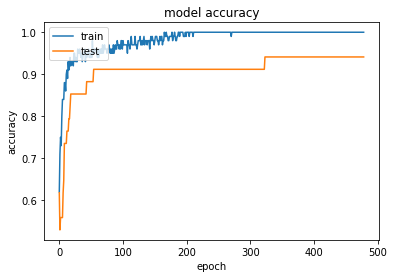

(0.9411765, 0.21977776288986206)

In [11]:
# train the model, will plot an accuracy char at the end
train_ngram_model()

## Finding new travelogues

In [12]:
# The code blocks below are used to identify new travelogues within the unclassified part of the corpus.
# Currently, those books are not included in our corpus repository, so this is disabled for now.

In [13]:
# load an already created model

# dependencies = {
#     'f1_score': f1_score,
#     'precision': precision,
#     'recall': recall
# }

# mlp_model = tf.keras.models.load_model(mlp_model_name, custom_objects=dependencies)

In [14]:
# loading the data

# import os
# import random
# import numpy as np
# from sklearn.model_selection import train_test_split
# from tqdm import tqdm

# travel_gt_path = books

# with open(result_output, 'a') as out_file:
#     out_file.write('Identifier,URL,Score\n')
    
#     candidate_path = os.path.join(travel_gt_path, 'candidates')
#     for fname in tqdm(os.listdir(candidate_path)):
#         text = []
#         if fname.endswith('.txt'):
#              with open(os.path.join(candidate_path, fname)) as f:
#                 text.append(f.read())
#                 vectorized_text = vectorizer.transform(text)
#                 vectorized_text = selector.transform(vectorized_text).astype('float32')
#                 score = model_17.predict(vectorized_text)[0][0]
#                 link = 'http://data.onb.ac.at/ABO/+%s' % fname[:-4]  # this links to the document in ABO
#                 out_file.write(fname[:-4] + ',' + link + ',' + str(format(score, '.5f')) + '\n')
